## Variables à ajouter issues des recherches biblio

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 

In [37]:
# !pip install ydata_profiling

In [37] used 0.0 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 13%), peaked 0.0 MiB above final usage, current RAM usage now 510.9 MiB


In [38]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)
from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

imu.start_watching_memory()



In [38] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 43%), peaked 0.0 MiB above final usage, current RAM usage now 510.9 MiB


# TODO -- Introduction  (Business Understanding) 

## TODO Détermination objectifs métier , analytique du projet 

## TODO Identifier les contraintes , limites et risque du projet

# 2. Data understanding (compréhension des données)


## 2.1.  Chargement des données

### Chargement des différentes bases de données + étude du chargement en mémoire

In [39]:
df = pd.read_csv("data/athlete_events.csv")
region_df = pd.read_csv("data/noc_regions.csv")
dictionary = pd.read_csv("data/dictionary.csv")

In [39] used 34.7 MiB RAM in 0.51s (system mean cpu 8%, single max cpu 100%), peaked 25.8 MiB above final usage, current RAM usage now 545.5 MiB


In [40]:
# méthode pour calculer la taille réelle occupée par le dataframe : les index occupent aussi de la place en mémoire
df.memory_usage(index=True).sum()

32534052

In [40] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 545.5 MiB


32534052 octets = 32,53 MB =  32534,052 KB.

## 2.2 Décrire les données

### Charger les données avec describe_csv et indiquer les types optimaux pour chaque colonne. 

In [41]:
describe_csv("data/athlete_events.csv", delimiter=',')

0 M rows approx.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
---------------------------------------------------
data/athlete_events.csv
---------------------------------------------------
       Col     type    min     max  nulls optimal type
0       ID    int64      1  135571      0        int32
1     Name   object      -       -      -       object
2      Sex   object      -       -      -       object
3      Age  float64   10.0    97.0   9474         int8
4   Height  float64  127.0   226.0  60171        int16
5   Weight  float64   25.0   214.0  62875        int16
6     Team   object      -       -      -       object
7      NOC   object      -       -      -       object
8    Games   object      -       -      -       object
9     Year    int64   1896    2016      0        int16
10  Season   object      -       -      -       object
11    City   object      -       -      -       object
12   Sport   object      -       -      -       object
13   Even

In [42]:
describe_csv("data/noc_regions.csv", delimiter=',')
describe_csv("data/dictionary.csv", delimiter=',')

0 M rows approx.
1 
---------------------------------------------------
data/noc_regions.csv
---------------------------------------------------
      Col    type min max nulls optimal type
0     NOC  object   -   -     -       object
1  region  object   -   -     -       object
2   notes  object   -   -     -       object

 0  rows
0 M rows approx.
1 
---------------------------------------------------
data/dictionary.csv
---------------------------------------------------
              Col     type         min            max nulls optimal type
0         Country   object           -              -     -       object
1            Code   object           -              -     -       object
2      Population  float64     10222.0   1371220000.0     5        int32
3  GDP per Capita  float64  277.068309  101449.968168    25      float32

 201  rows
In [42] used 0.0 MiB RAM in 0.12s (system mean cpu 45%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 550.7 MiB


### Nombre de données manquantes par feature

In [43]:
df.isna().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [43] used 0.0 MiB RAM in 0.17s (system mean cpu 19%, single max cpu 100%), peaked 2.6 MiB above final usage, current RAM usage now 550.7 MiB


## EDA

### Terget Medals : Nous allons construire des représentations graphiques nous permettant d'observer les Medals en fonction des autres variables.On effectue des transformations sur les données pour les besoins de cette analyse exploratoire (pas forcément les mêmes transformations que celles nécessaires lors de l'étape de Feature engineering).

In [44]:
df['Team'] = df['Team'].replace(['Soviet Union', 'URS'], 'Russia')
df['Team'] = df['Team'].replace(['East Germany'], 'Germany')


In [44] used 2.1 MiB RAM in 0.14s (system mean cpu 11%, single max cpu 100%), peaked 2.1 MiB above final usage, current RAM usage now 552.8 MiB


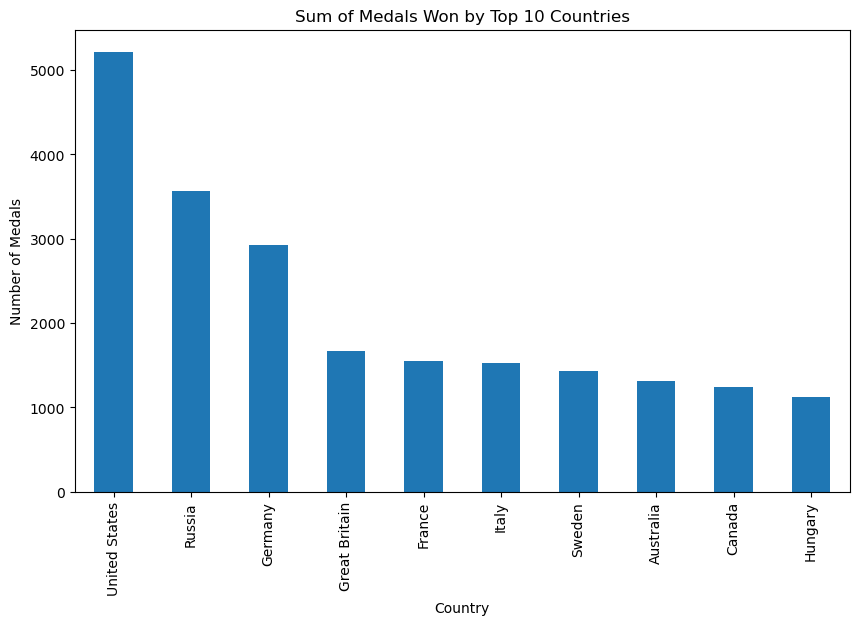

Sum of medals won by the top 10 countries: 21565
In [47] used 2.8 MiB RAM in 0.25s (system mean cpu 6%, single max cpu 33%), peaked 2.3 MiB above final usage, current RAM usage now 621.1 MiB


In [47]:
top_10_countries = df.groupby('Team')['Medal'].count().nlargest(10)
sum_of_medals = top_10_countries.sum()
# Plotting the sum of medals won by the top 10 countries
top_10_countries.plot(kind='bar', figsize=(10, 6))
plt.title('Sum of Medals Won by Top 10 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.show()
print("Sum of medals won by the top 10 countries:", sum_of_medals)


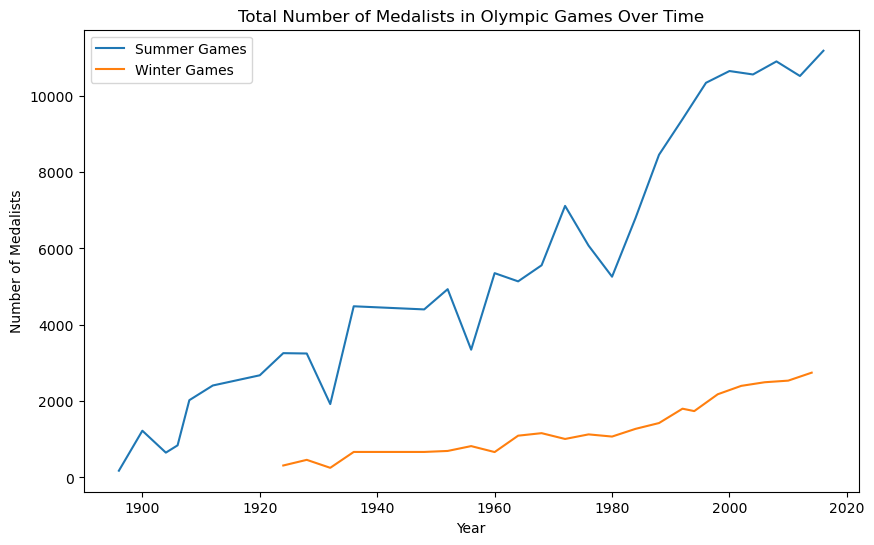

In [11] used 5.8 MiB RAM in 0.40s (system mean cpu 4%, single max cpu 100%), peaked 30.4 MiB above final usage, current RAM usage now 317.4 MiB


In [ ]:
# Group the data by year and count the number of unique medalists for summer games
summer_medalists = df[df['Season'] == 'Summer'].groupby('Year')['ID'].nunique()

# Group the data by year and count the number of unique medalists for winter games
winter_medalists = df[df['Season'] == 'Winter'].groupby('Year')['ID'].nunique()

# Plot the data using a line plot
plt.figure(figsize=(10, 6))
summer_medalists.plot(label='Summer Games')
winter_medalists.plot(label='Winter Games')
plt.title('Total Number of Medalists in Olympic Games Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Medalists')
plt.legend()
plt.show()


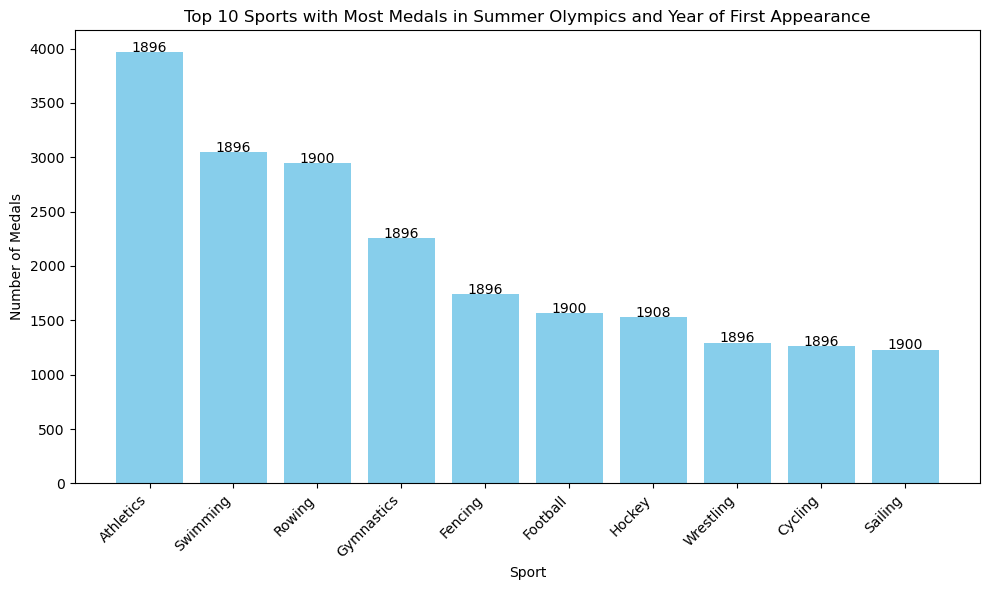

In [12] used 30.3 MiB RAM in 0.31s (system mean cpu 4%, single max cpu 100%), peaked 4.5 MiB above final usage, current RAM usage now 347.8 MiB


In [ ]:
# Medals per sport

import matplotlib.pyplot as plt

# Filtrer le DataFrame pour n'inclure que les Jeux Olympiques d'été
summer_df = df[df['Season'] == 'Summer']

# Créer une série indiquant la première apparition de chaque sport aux Jeux Olympiques
first_appearance = summer_df.groupby('Sport')['Year'].min()

# Compter le nombre de médailles remportées dans chaque sport
medal_counts_by_sport = summer_df.groupby('Sport')['Medal'].count()

# Fusionner les données de médailles et de première apparition
sport_data = pd.DataFrame({'Medal Count': medal_counts_by_sport, 'First Appearance': first_appearance})

# Trier les sports en fonction du nombre de médailles remportées
top_10_sports = sport_data.nlargest(10, 'Medal Count')

# Créer un graphique à barres pour visualiser les données
plt.figure(figsize=(10, 6))
plt.bar(top_10_sports.index, top_10_sports['Medal Count'], color='skyblue')

# Afficher la première apparition au-dessus de chaque barre
for i, sport in enumerate(top_10_sports.index):
    plt.text(i, top_10_sports.loc[sport, 'Medal Count'] + 0.5, str(top_10_sports.loc[sport, 'First Appearance']), ha='center')

plt.title('Top 10 Sports with Most Medals in Summer Olympics and Year of First Appearance')
plt.xlabel('Sport')
plt.ylabel('Number of Medals')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


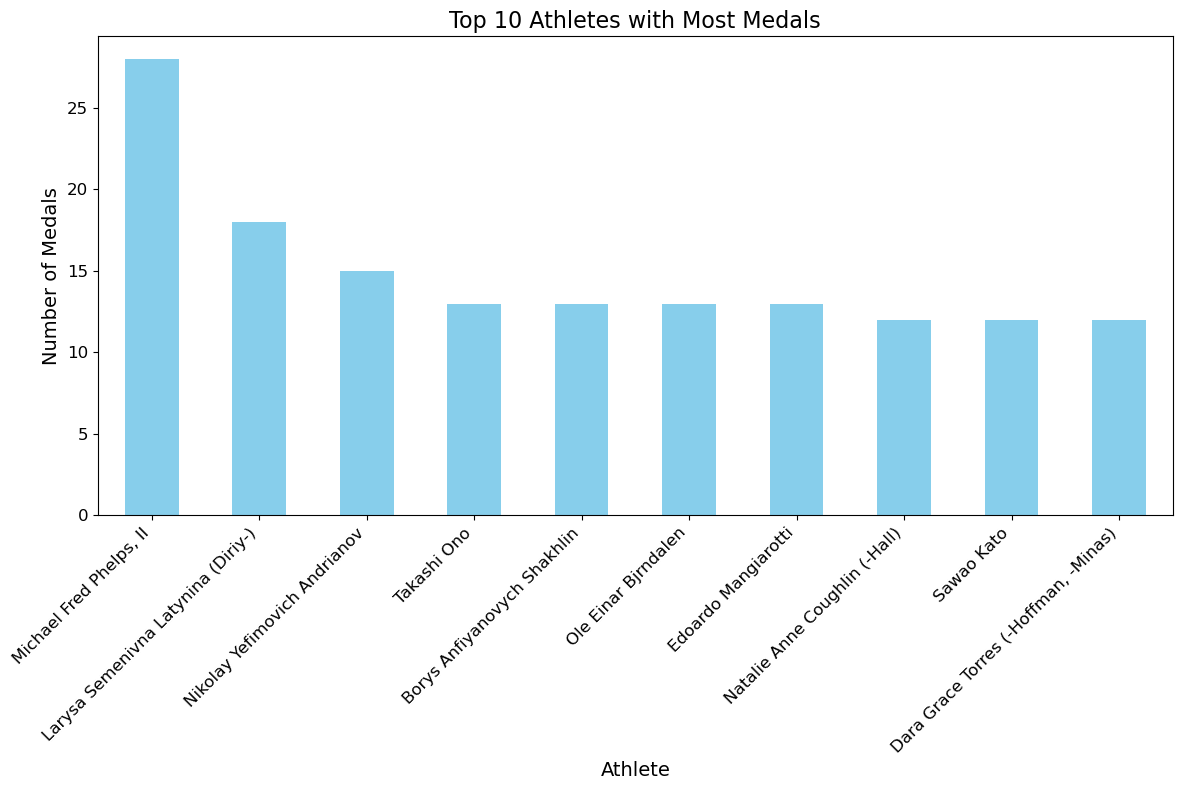

Name
Michael Fred Phelps, II                 28
Larysa Semenivna Latynina (Diriy-)      18
Nikolay Yefimovich Andrianov            15
Takashi Ono                             13
Borys Anfiyanovych Shakhlin             13
Ole Einar Bjrndalen                     13
Edoardo Mangiarotti                     13
Natalie Anne Coughlin (-Hall)           12
Sawao Kato                              12
Dara Grace Torres (-Hoffman, -Minas)    12
Name: Medal, dtype: int64
In [13] used 7.3 MiB RAM in 0.40s (system mean cpu 1%, single max cpu 43%), peaked 0.1 MiB above final usage, current RAM usage now 355.1 MiB


In [ ]:
import matplotlib.pyplot as plt

# Group the data by athlete name and count the number of medals
top_10_athletes = df.groupby('Name')['Medal'].count().sort_values(ascending=False).head(10)

# Plot the number of medals won by each athlete
plt.figure(figsize=(12, 8))
top_10_athletes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Athletes with Most Medals', fontsize=16)
plt.xlabel('Athlete', fontsize=14)
plt.ylabel('Number of Medals', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

print(top_10_athletes)


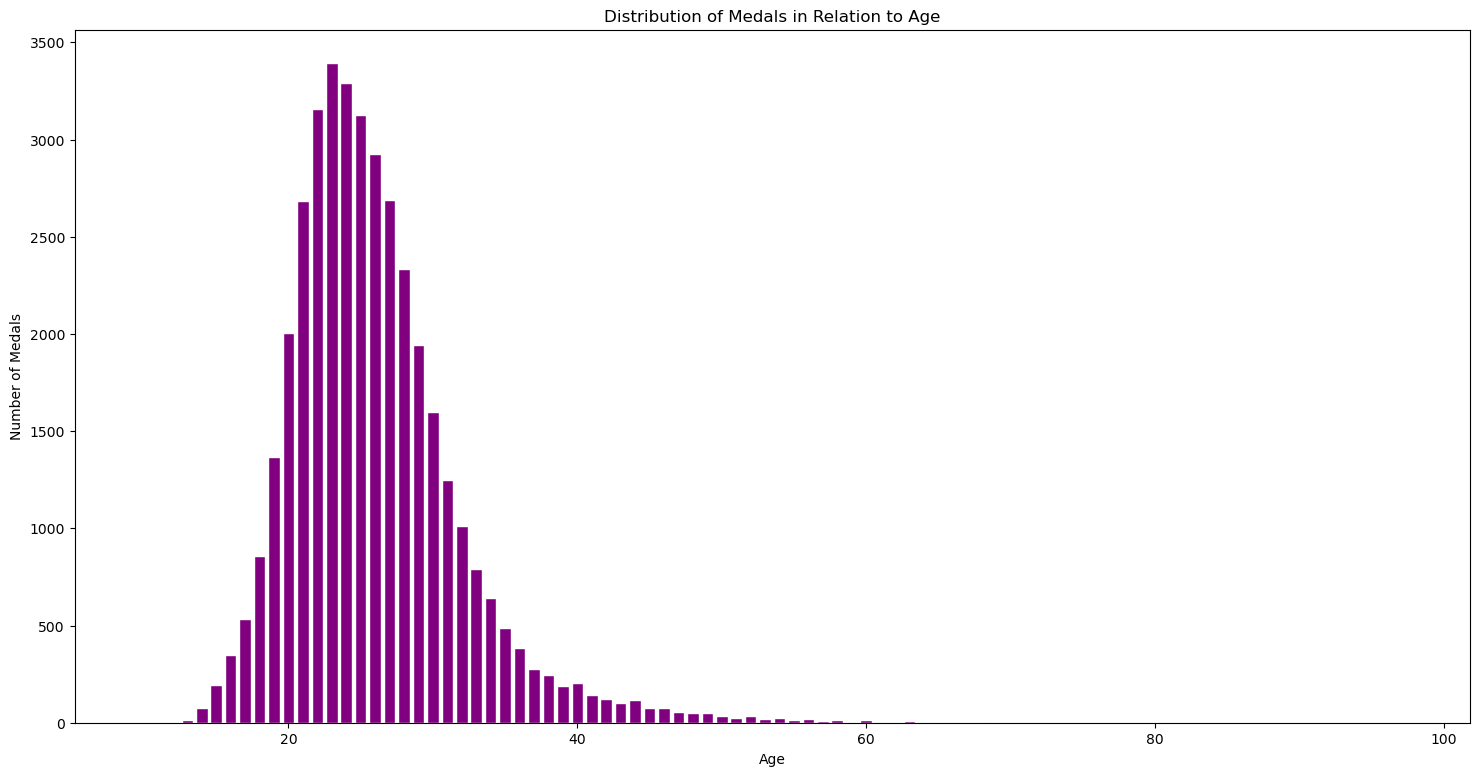

In [14] used 1.4 MiB RAM in 0.29s (system mean cpu 2%, single max cpu 100%), peaked 6.2 MiB above final usage, current RAM usage now 356.5 MiB


In [ ]:
# Medals per Age

# Group the data by age and count the number of medals for each age group
medals_by_age = df.groupby('Age')['Medal'].count()

# Plot the distribution of medals in relation to age
plt.figure(figsize=(18,9))
plt.title('Distribution of Medals in Relation to Age')
plt.xlabel('Age')
plt.ylabel('Number of Medals')
plt.bar(medals_by_age.index, medals_by_age.values, color='purple', edgecolor='white')
plt.show()


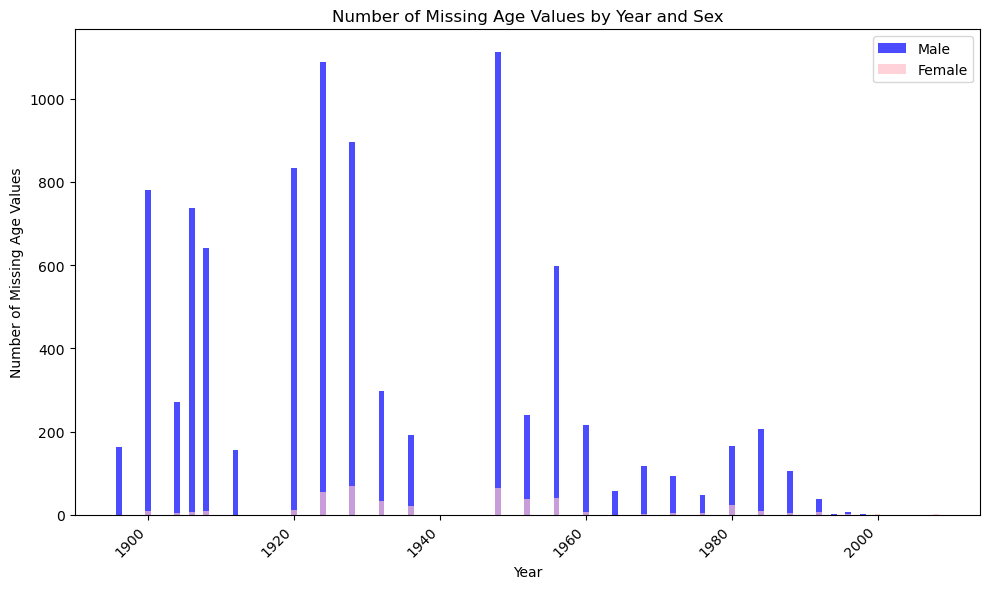

In [15] used -5.0 MiB RAM in 0.39s (system mean cpu 1%, single max cpu 100%), peaked 6.2 MiB above final usage, current RAM usage now 351.5 MiB


In [ ]:
import matplotlib.pyplot as plt

# Filtrer le DataFrame pour inclure uniquement les lignes où l'âge est manquant et par sexe
missing_age_male_df = df[(df['Age'].isnull()) & (df['Sex'] == 'M')]
missing_age_female_df = df[(df['Age'].isnull()) & (df['Sex'] == 'F')]

# Compter le nombre de valeurs d'âge manquantes pour chaque année pour les hommes et les femmes
missing_age_male_counts = missing_age_male_df.groupby('Year')['Year'].count()
missing_age_female_counts = missing_age_female_df.groupby('Year')['Year'].count()

# Créer un graphique en barres pour visualiser les comptages d'âge manquants par année pour les hommes et les femmes
plt.figure(figsize=(10, 6))
plt.bar(missing_age_male_counts.index, missing_age_male_counts.values, color='blue', alpha=0.7, label='Male')
plt.bar(missing_age_female_counts.index, missing_age_female_counts.values, color='pink', alpha=0.7, label='Female')

plt.title('Number of Missing Age Values by Year and Sex')
plt.xlabel('Year')
plt.ylabel('Number of Missing Age Values')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Fusion des bases + Nettoyage

In [ ]:
df = pd.read_csv("data/athlete_events.csv")
region_df = pd.read_csv("data/noc_regions.csv")

print(df.shape)

(271116, 15)
In [16] used 4.4 MiB RAM in 0.48s (system mean cpu 2%, single max cpu 100%), peaked 55.1 MiB above final usage, current RAM usage now 355.9 MiB


In [ ]:
#only summer season Analyis
df = df[df['Season'] == "Summer"]
print(df.shape)
df.head()

(222552, 15)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
26,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NaN


In [17] used -3.4 MiB RAM in 0.15s (system mean cpu 7%, single max cpu 67%), peaked 3.4 MiB above final usage, current RAM usage now 352.5 MiB


In [ ]:
print(region_df.shape)
region_df.head()

(230, 3)


,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [18] used 0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 352.5 MiB


In [ ]:
#merge df and region_df on the basis of NOC
# merge df and region_df on the basis of NOC, excluding the "notes" column
df = df.merge(region_df.drop(columns=['notes']), on="NOC", how="left")


In [19] used 27.7 MiB RAM in 0.14s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 380.2 MiB


In [ ]:
print(df.shape) # + 1 colonne (région = Team)
df.head()

(222552, 16)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NaN,Netherlands


In [20] used 0.0 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 380.2 MiB


In [ ]:
df["region"].unique()

array(['China', 'Denmark', 'Netherlands', 'Finland', 'Norway', 'Romania',
       'Estonia', 'France', 'Morocco', 'Spain', 'Egypt', 'Iran',
       'Bulgaria', 'Italy', 'Chad', 'Azerbaijan', 'Sudan', 'Russia',
       'Argentina', 'Cuba', 'Belarus', 'Greece', 'Cameroon', 'Turkey',
       'Chile', 'Mexico', 'USA', 'Nicaragua', 'Hungary', 'Nigeria',
       'Algeria', 'Kuwait', 'Bahrain', 'Pakistan', 'Iraq', 'Syria',
       'Lebanon', 'Qatar', 'Malaysia', 'Germany', 'Canada', 'Ireland',
       'Australia', 'South Africa', 'Eritrea', 'Tanzania', 'Jordan',
       'Tunisia', 'Libya', 'Belgium', 'Djibouti', 'Palestine', 'Comoros',
       'Kazakhstan', 'Brunei', 'India', 'Saudi Arabia', 'Maldives',
       'Ethiopia', 'United Arab Emirates', 'Yemen', 'Indonesia',
       'Philippines', nan, 'Uzbekistan', 'Kyrgyzstan', 'Tajikistan',
       'Japan', 'Republic of Congo', 'Switzerland', 'Brazil', 'Monaco',
       'Israel', 'Uruguay', 'Sweden', 'Sri Lanka', 'Armenia',
       'Ivory Coast', 'Kenya', 'Ben

In [21] used 0.0 MiB RAM in 0.11s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 380.2 MiB


In [ ]:
df["region"].unique().shape


(206,)

In [22] used 0.0 MiB RAM in 0.11s (system mean cpu 1%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 380.2 MiB


In [ ]:
df.isna().sum()

ID             0
Name           0
Sex            0
Age         9189
Height     51857
Weight     53854
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     188464
region       370
dtype: int64

In [23] used 0.5 MiB RAM in 0.15s (system mean cpu 8%, single max cpu 100%), peaked 2.1 MiB above final usage, current RAM usage now 380.7 MiB


In [ ]:
# removing duplicate
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [24] used 29.1 MiB RAM in 0.55s (system mean cpu 7%, single max cpu 100%), peaked 48.4 MiB above final usage, current RAM usage now 409.8 MiB


In [ ]:
df["Medal"].value_counts()

Medal
Gold      11456
Bronze    11409
Silver    11212
Name: count, dtype: int64

In [25] used 0.0 MiB RAM in 0.11s (system mean cpu 2%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 409.9 MiB


In [ ]:
#seperate column 
pd.get_dummies(df["Medal"])

,Bronze,Gold,Silver
0,False,False,False
1,False,False,False
2,False,False,False
3,False,True,False
4,False,False,False
...,...,...,...
222547,False,False,False
222548,False,False,False
222549,False,False,False
222550,False,False,False


In [26] used -0.0 MiB RAM in 0.12s (system mean cpu 3%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 409.9 MiB


In [ ]:
#to join***
df = pd.concat([df,pd.get_dummies(df["Medal"])],axis=1)

In [27] used 0.8 MiB RAM in 0.13s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 410.7 MiB


In [ ]:
df.shape

(221167, 19)

In [28] used -0.0 MiB RAM in 0.10s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 410.7 MiB


In [ ]:
#Groupby based on NOC 
df.groupby("NOC").sum()[["Gold","Silver","Bronze"]].sort_values("Gold",ascending=False).reset_index().head(25)

,NOC,Gold,Silver,Bronze
0,USA,2472,1333,1197
1,URS,832,635,596
2,GBR,635,729,620
3,GER,592,538,649
4,ITA,518,474,454
5,FRA,463,567,587
6,HUN,432,328,363
7,SWE,354,396,358
8,AUS,342,452,510
9,GDR,339,277,227


In [29] used 1.4 MiB RAM in 1.98s (system mean cpu 2%, single max cpu 100%), peaked 26.9 MiB above final usage, current RAM usage now 412.0 MiB


### Suppression des outliers, valeures aberrants, valeures nulles

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cols_to_impute = ['Year', 'Age', 'Height', 'Weight']
iter_imp = IterativeImputer(min_value=df[cols_to_impute].min(), max_value=df[cols_to_impute].max())
imputed_cols = iter_imp.fit_transform(df[cols_to_impute])
df[cols_to_impute] = imputed_cols
df['Medal'] = df['Medal'].fillna('NA')
df.isna().sum()


ID          0
Name        0
Sex         0
Age         0
Height      0
Weight      0
Team        0
NOC         0
Games       0
Year        0
Season      0
City        0
Sport       0
Event       0
Medal       0
region    370
Bronze      0
Gold        0
Silver      0
dtype: int64

In [30] used 17.4 MiB RAM in 1.18s (system mean cpu 1%, single max cpu 100%), peaked 37.7 MiB above final usage, current RAM usage now 429.4 MiB


In [ ]:
df.isna().sum()

ID          0
Name        0
Sex         0
Age         0
Height      0
Weight      0
Team        0
NOC         0
Games       0
Year        0
Season      0
City        0
Sport       0
Event       0
Medal       0
region    370
Bronze      0
Gold        0
Silver      0
dtype: int64

In [31] used 0.0 MiB RAM in 0.16s (system mean cpu 2%, single max cpu 100%), peaked 1.9 MiB above final usage, current RAM usage now 429.5 MiB


In [ ]:
#filling outliers with mean:

vars=["Age","Height","Weight"]

def fill_outliers_with_mean(df, variable, threshold=1.5):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    df.loc[(df[variable] < lower_bound) | (df[variable] > upper_bound), variable] = df[variable].mean()
    
for column in vars:
    fill_outliers_with_mean(df, column)

In [32] used 0.1 MiB RAM in 0.13s (system mean cpu 3%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 429.5 MiB


### Conversion de variables catégorielles en numériques : "Sex", "Season" et "Medal"


In [ ]:
# sparse = Will return sparse matrix if set True else will return an array.
encoder=preprocessing.OneHotEncoder(sparse_output=False)
encoder.fit(df[['Sex']])
columns_name = encoder.get_feature_names_out(['Sex'])
df_encoded = pd.DataFrame(encoder.transform(df[['Sex']]))
df_encoded.columns = columns_name

#df.drop(['Sex'] ,axis=1, inplace=True) --> on devrait supprimer la colonne encodée (on la garde ici pour vérif.)

df= pd.concat([df, df_encoded], axis=1)
df

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,City,Sport,Event,Medal,region,Bronze,Gold,Silver,Sex_F,Sex_M
0,1.0,A Dijiang,M,24.0,180.000000,80.000000,China,CHN,1992 Summer,1992.0,...,Barcelona,Basketball,Basketball Men's Basketball,NA,China,False,False,False,0.0,1.0
1,2.0,A Lamusi,M,23.0,170.000000,60.000000,China,CHN,2012 Summer,2012.0,...,London,Judo,Judo Men's Extra-Lightweight,NA,China,False,False,False,0.0,1.0
2,3.0,Gunnar Nielsen Aaby,M,24.0,173.902574,69.956616,Denmark,DEN,1920 Summer,1920.0,...,Antwerpen,Football,Football Men's Football,NA,Denmark,False,False,False,0.0,1.0
3,4.0,Edgar Lindenau Aabye,M,34.0,175.853588,75.140164,Denmark/Sweden,DEN,1900 Summer,1900.0,...,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,False,True,False,0.0,1.0
4,8.0,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.000000,61.830399,Netherlands,NED,1932 Summer,1932.0,...,Los Angeles,Athletics,Athletics Women's 100 metres,NA,Netherlands,False,False,False,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
220169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
220170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
220171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0


In [33] used 19.2 MiB RAM in 0.30s (system mean cpu 3%, single max cpu 100%), peaked 49.9 MiB above final usage, current RAM usage now 448.8 MiB


In [ ]:
# sparse = Will return sparse matrix if set True else will return an array.
encoder=preprocessing.OneHotEncoder(sparse_output=False)
encoder.fit(df[['Medal']])
columns_name = encoder.get_feature_names_out(['Medal'])
df_encoded = pd.DataFrame(encoder.transform(df[['Medal']]))
df_encoded.columns = columns_name

#df.drop(['Medal'] ,axis=1, inplace=True) --> on devrait supprimer la colonne encodée (on la garde ici pour vérif.)

df= pd.concat([df, df_encoded], axis=1)
df

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Bronze,Gold,Silver,Sex_F,Sex_M,Medal_Bronze,Medal_Gold,Medal_NA,Medal_Silver,Medal_nan
0,1.0,A Dijiang,M,24.0,180.000000,80.000000,China,CHN,1992 Summer,1992.0,...,False,False,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2.0,A Lamusi,M,23.0,170.000000,60.000000,China,CHN,2012 Summer,2012.0,...,False,False,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,Gunnar Nielsen Aaby,M,24.0,173.902574,69.956616,Denmark,DEN,1920 Summer,1920.0,...,False,False,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4.0,Edgar Lindenau Aabye,M,34.0,175.853588,75.140164,Denmark/Sweden,DEN,1900 Summer,1900.0,...,False,True,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,8.0,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.000000,61.830399,Netherlands,NED,1932 Summer,1932.0,...,False,False,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
221723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
221725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
221727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0


In [34] used 59.0 MiB RAM in 0.28s (system mean cpu 3%, single max cpu 100%), peaked 56.7 MiB above final usage, current RAM usage now 507.8 MiB
